## Purpose

This notebook is designed to generate the figures 2 - 6 found in the manuscript. 

In [1]:
import pingouin as pg
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
from scipy import stats

C:\Users\delzinga\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\delzinga\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Figure 2

PRCC plot. Dependent variable: Average (across the 10 repetitions) col siring proportion \*. Independent variables: parameters from the LHS. 

\* Repetitions with less than 10 fertilized ovules (in total) were discarded to match lab procedures. 

In [2]:
# Load in the double accession data. 
cols = ['LHS-paramcombo-counter', 'count patches with [pcolor = yellow]','count patches with [pcolor = blue] / 6', 'count patches with [pcolor = red] / 6']
fert_df = pd.read_csv(os.getcwd() + '\\Experiment Data\\calibration_data_double_accession', usecols = cols, skiprows=6, sep=',')

# Modify column names 
fert_df = fert_df.rename(columns={'count patches with [pcolor = yellow]': 'num_unfert_ovules',\
     'count patches with [pcolor = blue] / 6': 'num_col_ovules', 'count patches with [pcolor = red] / 6': 'num_ler_ovules',\
     'LHS-paramcombo-counter': 'param_num'})

In [3]:
# Remove repetitions with less than 10 fertilized ovules. 
fert_df = fert_df[fert_df['num_col_ovules'] + fert_df['num_ler_ovules'] >= 10]

# Calculate the siring proportion of col among the fertilized ovules. 
fert_df.loc[:,'col_fert_prop'] = fert_df.num_col_ovules / (fert_df.num_col_ovules + fert_df.num_ler_ovules)

# Group repetitions by their parameter number, calculate the mean siring proportion of col.
siring_prop_col_df = fert_df.groupby('param_num').mean()

In [4]:
# Read in the LHS, rename the columns.  
LHS_df = pd.read_csv(os.getcwd() + '\\Experiment Data\\LHS.csv', sep=',', header=None)
LHS_param_names = ['chemoattr. radius ler', 'chemoattr. radius col', 'initial energy', 'initial energy ler', 'initial energy col',\
     'max-energy harvest col', 'max-energy harvest ler', 'replenish-style', 'fert-threshold col', 'fert-threshold ler', 'prop fert cutoff',\
     'freq startch replenish', 'prop energy replenish', 'step size', 'movement cost ler', 'movement cost col', '$\kappa$']
LHS_df.columns = LHS_param_names

# Create a combined_vars_df which holds the independent variables and the dependent variable (last column)
combined_vars_df = LHS_df.loc[siring_prop_col_df.index.tolist()]
combined_vars_df['siring_prop_col'] = siring_prop_col_df['col_fert_prop']

# Rank transform the data. 
combined_vars_df = combined_vars_df.rank()

In [5]:
# Perform the PRCC analysis. 
PRCC_df = combined_vars_df.pcorr().round(3)

# Get the p-values of the analysis. 
pvals_df = combined_vars_df.rcorr().round(3)

In [6]:
# Show the pvalues so we can identify which ones are significant at the 0.01 level. 
pvals_df

,chemoattr. radius ler,chemoattr. radius col,initial energy,initial energy ler,initial energy col,max-energy harvest col,max-energy harvest ler,replenish-style,fert-threshold col,fert-threshold ler,prop fert cutoff,freq startch replenish,prop energy replenish,step size,movement cost ler,movement cost col,$\kappa$,siring_prop_col
chemoattr. radius ler,-,***,,**,*,***,*,,,,,,,,***,***,,***
chemoattr. radius col,-0.478,-,*,,,***,*,,,,*,,,*,***,***,,***
initial energy,0.022,-0.036,-,,**,,,,,,,,,***,,**,,
initial energy ler,0.047,-0.013,-0.001,-,,,,,,,,,,,,,,*
initial energy col,-0.035,-0.017,-0.043,-0.027,-,,,,,,,,**,,,,,
max-energy harvest col,-0.059,0.069,-0.02,0.004,-0.029,-,,,,*,,,,,,,,***
max-energy harvest ler,0.034,-0.032,0.023,0.017,-0.014,0.009,-,,,,,,,,,,,***
replenish-style,0.016,-0.014,-0.012,-0.004,-0.027,-0.012,0.016,-,,,,,,*,,,,
fert-threshold col,0.002,-0.006,0.025,0.006,0.027,0.018,-0.006,-0.022,-,,,,,,,**,,
fert-threshold ler,-0.031,0.024,-0.004,-0.03,-0.011,0.038,0.005,-0.021,0.005,-,,,*,,*,,,**


In [7]:
# Record the significant variables.
sig_vars = ['chemoattr. radius ler', 'chemoattr. radius col', 'max-energy harvest col', 
            'max-energy harvest ler', 'fert-threshold ler', 'movement cost ler',
           'movement cost col']

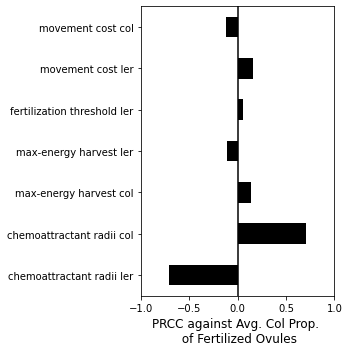

In [21]:
# Create a dataframe to hold the values for the bar plot. 
plot_df = pd.DataFrame({'PRCC_val' : PRCC_df['siring_prop_col'][sig_vars].rename({
    'chemoattr. radius ler': 'chemoattractant radii ler',
    'chemoattr. radius col': 'chemoattractant radii col',
    'fert-threshold ler': 'fertilization threshold ler'
})})

fig = plot_df.plot.barh(color='black', legend=None)
plt.rcParams["figure.figsize"] = (5,5)
fig.plot([0,0], [-1,10], color='black')
fig.set_xlim(-1,1); #fig.set_xticklabels(sig_vars, rotation = 90)
fig.set_xlabel('PRCC against Avg. Col Prop. \n of Fertilized Ovules', fontsize = 12)
plt.tight_layout()
plt.savefig('Figure2.pdf')
plt.show()

### Figure 3ab

Histogram of proportion of parameters against average (across the 10 repetitions) col siring proportion\* within those parameters. 

\* Repetitions with less than 10 fertilized ovules (in total) were discarded to match lab procedures. 

In [ ]:
# Load in the double accession data. 
cols = ['LHS-paramcombo-counter', 'count patches with [pcolor = yellow]','count patches with [pcolor = blue] / 6', 'count patches with [pcolor = red] / 6']
fert_df = pd.read_csv(os.getcwd() + '\\Experiment Data\\calibration_data_double_accession', usecols = cols, skiprows=6, sep=',')

# Modify column names 
fert_df = fert_df.rename(columns={'count patches with [pcolor = yellow]': 'num_unfert_ovules',\
     'count patches with [pcolor = blue] / 6': 'num_col_ovules', 'count patches with [pcolor = red] / 6': 'num_ler_ovules',\
     'LHS-paramcombo-counter': 'param_num'})

In [ ]:
# Load in the MLFO and DFO rankings. 
MLFO_ranks = pickle.load(open("MLFO_ranks.pickle","rb"))
DFO_ranks = pickle.load(open("DFO_ranks.pickle","rb"))

In [ ]:
# Remove repetitions with less than 10 fertilized ovules. 
fert_df = fert_df[fert_df['num_col_ovules'] + fert_df['num_ler_ovules'] >= 10]

# Calculate the siring proportion of col among the fertilized ovules. 
fert_df.loc[:,'col_fert_prop'] = fert_df.num_col_ovules / (fert_df.num_col_ovules + fert_df.num_ler_ovules)

# Group repetitions by their parameter number, calculate the mean siring proportion of col.
siring_prop_col_df = fert_df.groupby('param_num').mean()

In [ ]:
plt.hist(siring_prop_col_df['col_fert_prop'], bins=15, density=True, alpha=0.3, label='All parameters')
plt.hist(siring_prop_col_df.loc[siring_prop_col_df.index.intersection(MLFO_ranks.nsmallest(n=100).index.tolist()),'col_fert_prop'],
         bins=15, density=True, alpha=0.3, label='MLFO Top 1%')
plt.axvline(0.93012, color='green', label='Empirical')
plt.axvline(siring_prop_col_df.loc[MLFO_ranks.nsmallest(n=1).index.tolist()]['col_fert_prop'].values, color='red',
            label='Top parameter combo. (MLFO)')
plt.axvline(siring_prop_col_df.loc[siring_prop_col_df.index.intersection(MLFO_ranks.nsmallest(n=100).index.tolist()),'col_fert_prop'].mean(),
            color='purple', label='Mean MLFO Top 1%')
plt.ylim(0,10)
plt.xlabel('Avg Col Prop. of Fertilized Ovules', fontsize = 12); plt.ylabel('Prob. Density', fontsize = 12)
plt.legend()
plt.tight_layout()
plt.savefig('Figure3a.pdf')
plt.show()

In [ ]:
# Calculate a 95% CI for the top 100 calibration parameters estimation of the mean of col siring proportion.
tube_data = siring_prop_col_df.loc[siring_prop_col_df.index.intersection(MLFO_ranks.nsmallest(n=100).index.tolist()),'col_fert_prop']
stats.t.interval(0.95, len(tube_data) - 1, loc=tube_data.mean(), scale=stats.sem(tube_data))

In [ ]:
plt.hist(siring_prop_col_df['col_fert_prop'], bins=15, density=True, alpha=0.3, label='All parameters')
plt.hist(siring_prop_col_df.loc[siring_prop_col_df.index.intersection(DFO_ranks.nsmallest(n=100).index.tolist()),'col_fert_prop'],
         bins=15, density=True, alpha=0.3, label='DFO Top 1%')
plt.axvline(0.93012, color='green', label='Empirical')
plt.axvline(siring_prop_col_df.loc[DFO_ranks.nsmallest(n=1).index.tolist()]['col_fert_prop'].values, color='red',
            label='Top parameter combo. (DFO)')
plt.axvline(siring_prop_col_df.loc[siring_prop_col_df.index.intersection(DFO_ranks.nsmallest(n=100).index.tolist()),'col_fert_prop'].mean(),
            color='purple', label='Mean DFO Top 1%')
plt.ylim(0,10)
plt.xlabel('Avg Col Prop. of Fertilized Ovules', fontsize = 12); plt.ylabel('Prob. Density', fontsize = 12)
plt.legend()
plt.tight_layout()
plt.savefig('Figure3b.pdf')
plt.show()

In [ ]:
# Calculate a 95% CI for the top 100 calibration parameters estimation of the mean of col siring proportion.
tube_data = siring_prop_col_df.loc[siring_prop_col_df.index.intersection(DFO_ranks.nsmallest(n=100).index.tolist()),'col_fert_prop']
stats.t.interval(0.95, len(tube_data) - 1, loc=tube_data.mean(), scale=stats.sem(tube_data))

### Figure 4a

In [ ]:
# Load in the single accession data. 
cols = ['LHS-paramcombo-counter', 'accession', 'r24L']
single_acc_df = pd.read_csv(os.getcwd() + '\\Experiment Data\\calibration_data_single_accession', usecols = cols, skiprows=6, sep=',')

In [ ]:
# Load in the double accession data. 
cols = ['LHS-paramcombo-counter', 'r24L']
double_acc_df = pd.read_csv(os.getcwd() + '\\Experiment Data\\calibration_data_double_accession', usecols = cols, skiprows=6, sep=',')

In [ ]:
# Load in the MLFO and DFO rankings. 
MLFO_ranks = pickle.load(open("MLFO_ranks.pickle","rb"))
DFO_ranks = pickle.load(open("DFO_ranks.pickle","rb"))

In [ ]:
# Using the MLFO top parameter, plot the pollen tube 
MLFO_best_ler = single_acc_df[(single_acc_df['LHS-paramcombo-counter'] == MLFO_ranks.nsmallest(n=1).index.tolist()[0]) & (single_acc_df['accession'] == 'ler-only')]
MLFO_best_double = double_acc_df[double_acc_df['LHS-paramcombo-counter'] == MLFO_ranks.nsmallest(n=1).index.tolist()[0]]

In [ ]:
def tube_clean(tubes):
    
    # Inputs
    # tubes - string object of space separated pollen tube lengths. 
    
    # Outputs:
    # tubes - numpy array of the input without zeros. 

    tubes = tubes.replace(" ",",")
    tubes = np.array(ast.literal_eval(tubes))
    
    if tubes.any() != 0:
        new_tubes = tubes[np.nonzero(tubes)]
    else:
        new_tubes = []
    
    return new_tubes

In [ ]:
ler_alone_tubes = []
col_and_ler_tubes = []
for r in range(len(MLFO_best_ler)):
    ler_alone_tubes = ler_alone_tubes + tube_clean(MLFO_best_ler.iloc[r].r24L).tolist()
    col_and_ler_tubes = col_and_ler_tubes + tube_clean(MLFO_best_double.iloc[r].r24L).tolist()

In [ ]:
bin_list = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 1.0]
plt.hist(ler_alone_tubes, bins=bin_list, alpha=0.3, color='r', density=True, label='Ler alone')
plt.hist(col_and_ler_tubes, bins=bin_list, alpha=0.3, color='k', density=True, label='Col and Ler')
plt.rcParams["figure.figsize"] = (5,5)
plt.yscale('log')
plt.ylabel('log(Prob. Density)', fontsize=12); plt.xlabel('Pollen tube length (mm)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('Figure4a.pdf')
plt.show()

### Figure 4b

In [ ]:
# Load in the single accession data. 
cols = ['LHS-paramcombo-counter', 'accession', 'r3L', 'r6L', 'r9L', 'r24L']
single_acc_df = pd.read_csv(os.getcwd() + '\\Experiment Data\\calibration_data_single_accession', usecols = cols, skiprows=6, sep=',')

In [ ]:
# Load in the double accession data. 
cols = ['LHS-paramcombo-counter', 'r3L', 'r6L', 'r9L', 'r24L']
double_acc_df = pd.read_csv(os.getcwd() + '\\Experiment Data\\calibration_data_double_accession', usecols = cols, skiprows=6, sep=',')

In [ ]:
# Load in the MLFO and DFO rankings. 
MLFO_ranks = pickle.load(open("MLFO_ranks.pickle","rb"))
DFO_ranks = pickle.load(open("DFO_ranks.pickle","rb"))

In [ ]:
def tube_clean(tubes):
    
    # Inputs
    # tubes - string object of space separated pollen tube lengths. 
    
    # Outputs:
    # tubes - numpy array of the input without zeros. 

    tubes = tubes.replace(" ",",")
    tubes = np.array(ast.literal_eval(tubes))
    
    if tubes.any() != 0:
        new_tubes = tubes[np.nonzero(tubes)]
    else:
        new_tubes = []
    
    return new_tubes

In [ ]:
# Create a list of lists with the following: each row corresponds to a parameter combination, an each entry is:
# pval of KS test trying to detect difference between the distribution of Ler pollen tube lengths without Col
# vs with Col when combining all repetitions at 3 hours post-germination. 
# 1, 2, 3, are the same but at 6, 9, and 24 hours post-germination. 

intf_MLFO_results = []
# Iterate through each parameter. 
for p in range(100):
    
    if p % 10 == 0:
        print(str(p) + '%')
        
    # Identify the correct parameter number from its ranking.  
    ler_wo_col_runs = single_acc_df[(single_acc_df['LHS-paramcombo-counter'] == MLFO_ranks.nsmallest(n=p+1).index.tolist()[-1]) & (single_acc_df['accession'] == 'ler-only')]
    ler_w_col_runs = double_acc_df[double_acc_df['LHS-paramcombo-counter'] == MLFO_ranks.nsmallest(n=p+1).index.tolist()[-1]]
    
    # Create a list to hold the pvalues for this parameter combination at the three different times. 
    pvals = []
    
    # Perform the following for each time frame. 
    for n, t in enumerate([3, 6, 9, 24]): 
        
        # Iterate through the subset dataframe, clean the tube lengths, organizing them based on if Col was present.
        ler_lengths_w_col = []
        ler_lengths_wo_col = []
        for r in range(len(ler_w_col_runs)):
            ler_lengths_w_col = ler_lengths_w_col + list(tube_clean(ler_wo_col_runs.iloc[r]['r' + str(t) + 'L']))
        for r in range(len(ler_wo_col_runs)):
            ler_lengths_wo_col = ler_lengths_wo_col + list(tube_clean(ler_w_col_runs.iloc[r]['r' + str(t) + 'L']))
        
        # Now conduct a two-sample KS test. 
        pvals.append(stats.ks_2samp(ler_lengths_w_col, ler_lengths_wo_col, alternative='less')[1])
    
    # Append the results for the four time values to the larger df holding the results. 
    intf_MLFO_results.append(pvals)

In [ ]:
# Repeat process for DFO

intf_DFO_results = []
# Iterate through each parameter. 
for p in range(100):
    
    if p % 10 == 0:
        print(str(p) + '%')
        
    # Identify the correct parameter number from its ranking.  
    ler_wo_col_runs = single_acc_df[(single_acc_df['LHS-paramcombo-counter'] == DFO_ranks.nsmallest(n=p+1).index.tolist()[-1]) & (single_acc_df['accession'] == 'ler-only')]
    ler_w_col_runs = double_acc_df[double_acc_df['LHS-paramcombo-counter'] == DFO_ranks.nsmallest(n=p+1).index.tolist()[-1]]
    
    # Create a list to hold the pvalues for this parameter combination at the three different times. 
    pvals = []
    
    # Perform the following for each time frame. 
    for n, t in enumerate([3, 6, 9, 24]): 
        
        # Iterate through the subset dataframe, clean the tube lengths, organizing them based on if Col was present.
        ler_lengths_w_col = []
        ler_lengths_wo_col = []
        for r in range(len(ler_w_col_runs)):
            ler_lengths_w_col = ler_lengths_w_col + list(tube_clean(ler_wo_col_runs.iloc[r]['r' + str(t) + 'L']))
        for r in range(len(ler_wo_col_runs)):
            ler_lengths_wo_col = ler_lengths_wo_col + list(tube_clean(ler_w_col_runs.iloc[r]['r' + str(t) + 'L']))
        
        # Now conduct a two-sample KS test. 
        pvals.append(stats.ks_2samp(ler_lengths_w_col, ler_lengths_wo_col, alternative='less')[1])
    
    # Append the results for the four time values to the larger df holding the results. 
    intf_DFO_results.append(pvals)

In [ ]:
# Use Holm-Bonferroni
num_sig_MLFO = []
num_sig_DFO = []
for t in range(4):
    num_sig_MLFO.append(np.sum(np.sort(np.array(intf_MLFO_results)[:,t]) < 0.05/(101 - np.arange(1,101,1) + 1)))
    num_sig_DFO.append(np.sum(np.sort(np.array(intf_DFO_results)[:,t]) < 0.05/(101 - np.arange(1,101,1) + 1)))

In [ ]:
intf_plot_df = pd.DataFrame({'MLFO' : num_sig_MLFO,
                             'DFO' : num_sig_DFO},
                            index = ['3hrs', '6hrs', '9hrs', '24hrs'])


fig = intf_plot_df.plot.bar(rot = 0)
plt.rcParams["figure.figsize"] = (5,5)
fig.set_ylim(0,105)
fig.set_xlabel('Number of hours post-germination', fontsize = 12)
fig.set_ylabel('Number of parameter combinations \n with Interference', fontsize = 12)
fig.legend(loc='upper left')
for p in fig.patches:
    fig.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
fig.set_yticks = [50, 60, 70, 80, 90, 100]  
fig.set_yticklabels = ['50', '60', '70', '80', '90', '100'] 
plt.tight_layout()
plt.savefig('Figure4b.pdf')
plt.show()

### Figure 5ab

In [ ]:
# Read in the interference data for both calibrations, store them in data frames. 
cols = ['prop-ler', 'count patches with [pcolor = yellow]', 'count patches with [pcolor = blue] / 6', 'count patches with [pcolor = red] / 6']
lerdom_MLFO_df = pd.read_csv(os.getcwd() + '\\Experiment Data\\ler_dominance_data_MLFO.csv', usecols=cols, skiprows=6, sep=',')
lerdom_DFO_df = pd.read_csv(os.getcwd() + '\\Experiment Data\\ler_dominance_data_DFO.csv', usecols=cols, skiprows=6, sep=',')

# Modify column names 
lerdom_MLFO_df = lerdom_MLFO_df.rename(columns={'count patches with [pcolor = yellow]': 'num_unfert_ovules',\
     'count patches with [pcolor = blue] / 6': 'num_col_ovules', 'count patches with [pcolor = red] / 6': 'num_ler_ovules',\
     'LHS-paramcombo-counter': 'param_num'})
lerdom_DFO_df = lerdom_DFO_df.rename(columns={'count patches with [pcolor = yellow]': 'num_unfert_ovules',\
     'count patches with [pcolor = blue] / 6': 'num_col_ovules', 'count patches with [pcolor = red] / 6': 'num_ler_ovules',\
     'LHS-paramcombo-counter': 'param_num'})

In [ ]:
# Remove repetitions with less than 10 fertilized ovules. 
lerdom_MLFO_df = lerdom_MLFO_df[lerdom_MLFO_df['num_col_ovules'] + lerdom_MLFO_df['num_ler_ovules'] >= 10]
lerdom_DFO_df = lerdom_DFO_df[lerdom_DFO_df['num_col_ovules'] + lerdom_DFO_df['num_ler_ovules'] >= 10]

# Calculate the proportion of siring that ler produces. 
lerdom_MLFO_df['ler_sire_prop'] = lerdom_MLFO_df['num_ler_ovules'] / (lerdom_MLFO_df['num_col_ovules'] + lerdom_MLFO_df['num_ler_ovules'])
lerdom_DFO_df['ler_sire_prop'] = lerdom_DFO_df['num_ler_ovules'] / (lerdom_DFO_df['num_col_ovules'] + lerdom_DFO_df['num_ler_ovules'])

In [ ]:
# Iterate through the proportions of ler that are placed, calculate the sample mean and the confidence interval (95%)
# for the population mean of ler proportion. 
sample_mean = []
upper95 = []
lower95 = []
ler_props = [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98]
for p in ler_props:
    prop_data = lerdom_MLFO_df[lerdom_MLFO_df['prop-ler'] == p].ler_sire_prop
    sample_mean.append(prop_data.mean())
    ci_nums = stats.t.interval(0.95, len(prop_data) - 1, loc=prop_data.mean(), scale=stats.sem(prop_data))
    upper95.append(ci_nums[1]); lower95.append(ci_nums[0])
    
ler_props.append(1); sample_mean.append(1); upper95.append(1); lower95.append(1)

In [ ]:
plt.xlabel("Ler Pollination Proportion", fontsize = 15)
plt.ylabel("Ler Fertilization Proportion", fontsize = 15)
inital_ler_props = np.linspace(0.5,1,26)
plt.ylim(0,1.1)
plt.plot(ler_props,sample_mean, label='Model mean')
plt.fill_between(ler_props,lower95,upper95,alpha=0.3, color='r',label='95% CI')
plt.hlines(0.5, 0.5, 0.935,linestyles='dashed',color='g',label='Equal Sire Prop.')
plt.vlines(0.935,0,0.5,linestyles='dashed',color='g')
plt.plot(0.8, 1-0.56,'kd',label='Empirical $\pm$ 2SE'); plt.errorbar(0.8, 1-0.56, 2*0.14269/3, color='black')
plt.plot(0.94, 1-0.26,'kd'); plt.errorbar(0.94, 1-0.26, 2*0.14671/3, color='black')

plt.legend()
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 0.935, 1.0],labels=[0.5, 0.6, 0.7, 0.8, 0.9, 0.935, 1.0],rotation =90)
plt.tight_layout()
plt.savefig('Figure5a.pdf')
plt.show()

In [ ]:
# Iterate through the proportions of ler that are placed, calculate the sample mean and the confidence interval (95%)
# for the population mean of ler proportion. 
sample_mean = []
upper95 = []
lower95 = []
ler_props = [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98]
for p in ler_props:
    prop_data = lerdom_DFO_df[lerdom_DFO_df['prop-ler'] == p].ler_sire_prop
    sample_mean.append(prop_data.mean())
    ci_nums = stats.t.interval(0.95, len(prop_data) - 1, loc=prop_data.mean(), scale=stats.sem(prop_data))
    upper95.append(ci_nums[1]); lower95.append(ci_nums[0])
    
ler_props.append(1); sample_mean.append(1); upper95.append(1); lower95.append(1)

In [ ]:
plt.xlabel("Ler Pollination Proportion", fontsize = 15)
plt.ylabel("Ler Fertilization Proportion", fontsize = 15)
inital_ler_props = np.linspace(0.5,1,26)
plt.ylim(0,1.1)
plt.plot(ler_props,sample_mean, label='Model mean')
plt.fill_between(ler_props,lower95,upper95,alpha=0.3, color='r',label='95% CI')
plt.hlines(0.5, 0.5, 0.84,linestyles='dashed',color='g')
plt.vlines(0.84,0,0.5,linestyles='dashed',color='g', label='Equal Sire Prop.')

plt.plot(0.8, 1-0.56,'kd',label='Empirical $\pm$ 2SE'); plt.errorbar(0.8, 1-0.56, 2*0.14269/3, color='black')
plt.plot(0.94, 1-0.26,'kd'); plt.errorbar(0.94, 1-0.26, 2*0.14671/3, color='black')

plt.legend()
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.84, 0.9, 1.0],labels=[0.5, 0.6, 0.7, 0.8, 0.84, 0.9, 1.0], rotation =90)
plt.tight_layout()
plt.savefig('Figure5b.pdf')
plt.show()